<a href="https://colab.research.google.com/github/lhmin0614/Randomly_Wired_NN/blob/main/Randwire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#imprt libraries
import math
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

## Import Dataset and Preprocessing

In [ ]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.5.0


In [ ]:
BATCH_SIZE = 32 
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
#Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]
 
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]
    
    plt.xlabel(classes[class_index])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])

# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


CIFAR dataset

170500096/170498071 [==============================] - 13s 0us/step


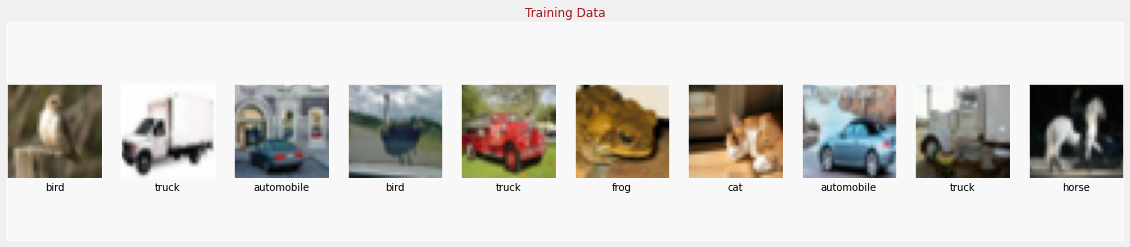

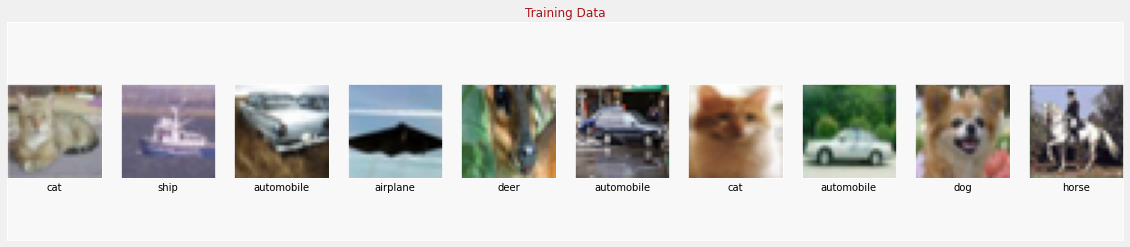

In [ ]:
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()
display_images(training_images, training_labels, training_labels, "Training Data" )
display_images(validation_images, validation_labels, validation_labels, "Training Data" )
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims
train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

## Random Graph Generator

In [ ]:
def er_graph(n, p = 0.2):

  if p < math.log(n) / n:
      print("p is too small for given n.")
      # p> ln(n)/n이어야 single connected component graph가 될 확률이 높다.

  edges = list()
  # n by n random array
  # rand[i][j] == the probability of the edge(i,j) connected.
  rand = np.random.uniform(0.0, 1.0, size=(n, n))

  for i in range(n):
      for j in range(i+1, n):
          if rand[i][j] < p:
              edges.append((i, j)) 

  return edges

In [ ]:
def ba_graph(n, m = 4):

  assert 1 <= m < n, "m must be smaller than n."

  edges = list()
  deg = np.zeros(n)

  for i in range(m, n):
      if i == m:
          for j in range(i):
              edges.append((j, i))
              deg[j] += 1
              deg[i] += 1
          continue

      connection = np.random.choice(range(n), size=m, replace=False, p=deg/np.sum(deg))
      for cnt in connection:
          edges.append((cnt, i))
          deg[cnt] += 1
          deg[i] += 1

  edges.sort()
  
  return edges

In [ ]:
def ws_graph(n, k = 4, p = 0.75):
  
  if k % 2 != 0:                            # k should be even
    k = k - 1

  init_edges = [[] for i in range(n)]
  rand = np.random.uniform(0.0, 1.0, (n, k//2))
  edges = list()

  for i in range(n):                        # each node is connected to k neighbor nodes.
    for j in range(k//2):
      jj = (i + j + 1) % n
      init_edges[i].append(jj)
      init_edges[jj].append(i)

  for i in range(n):
    for j in range(k//2):
      jj = (i + j + 1) % n
      jjj = jj
      if rand[i][j] < p:
        rand_list = list(set(range(n)) - {i} - set(init_edges[i]))
        jjj = np.random.choice(rand_list, 1)[0]
        init_edges[i].append(jjj)
        init_edges[jjj].append(i)
        init_edges[i].remove(jj)
        init_edges[jj].remove(i)
      edges.append(tuple(sorted([i, jjj])))
  
  return sorted(edges)

In [ ]:
def in_out_nodes(n, edges):
  vertices = set(range(n))
  starts, ends = set(), set()

  for edge in edges:
    starts.add(edge[0])
    ends.add(edge[1])
  
  inputs = sorted(list(vertices - ends))
  outputs = sorted(list(vertices - starts))

  return inputs, outputs

def find_inputs(edges, i):
  i_inputs = []

  for edge in edges:
    if edge[1] == i:
      i_inputs.append(edge[0])
  
  return i_inputs

In [ ]:
er1 = er_graph(20, 0.2)
ba1 = ba_graph(20, 4)
ws1 = ws_graph(20, 4, 0.75)

print(er1)
print(in_out_nodes(20, er1), end='\n\n')
print(ba1)
print(in_out_nodes(20, ba1), end='\n\n')
print(ws1)
print(in_out_nodes(20, ws1))

[(0, 4), (0, 5), (0, 7), (0, 11), (0, 17), (1, 5), (1, 12), (2, 4), (2, 5), (3, 4), (3, 6), (3, 11), (3, 16), (3, 17), (3, 18), (4, 7), (4, 9), (4, 16), (7, 8), (8, 11), (8, 12), (8, 15), (9, 14), (12, 13), (12, 18), (13, 17), (14, 16), (14, 17), (14, 18), (15, 16), (15, 18), (17, 18), (17, 19)]
([0, 1, 2, 3, 10], [5, 6, 10, 11, 16, 18, 19])

[(0, 4), (0, 5), (0, 6), (0, 9), (0, 12), (0, 18), (1, 4), (1, 8), (2, 4), (2, 5), (2, 6), (2, 9), (2, 10), (2, 11), (2, 16), (2, 18), (2, 19), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 10), (3, 13), (4, 5), (4, 7), (4, 9), (4, 10), (4, 11), (4, 13), (4, 15), (4, 18), (4, 19), (5, 6), (5, 7), (5, 8), (6, 7), (6, 8), (6, 9), (6, 11), (6, 12), (6, 14), (6, 15), (6, 16), (6, 17), (6, 18), (7, 10), (7, 11), (7, 12), (7, 14), (7, 15), (7, 17), (8, 14), (8, 16), (9, 12), (9, 13), (9, 14), (9, 17), (9, 19), (10, 13), (12, 17), (14, 15), (14, 16), (14, 19)]
([0, 1, 2, 3], [11, 13, 15, 16, 17, 18, 19])

[(0, 1), (0, 8), (0, 10), (1, 2), (1, 12), (1, 13),

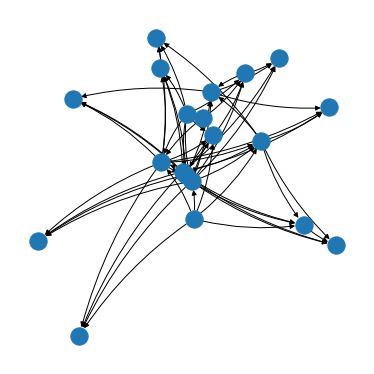

In [ ]:
####################################
#    VIsualize random DAG graph    #
####################################
import matplotlib.pyplot as plt
import networkx as nx

# create a directed multi-graph
G = nx.MultiDiGraph()
G.add_edges_from(ba1)

plt.figure(figsize=(5,5))
nx.draw(G, connectionstyle='arc3, rad = 0.1')
plt.show() 

## Network Generator

In [ ]:
class Weighted_Sum(layers.Layer):
  def __init__(self, n_inputs):
    super(Weighted_Sum, self).__init__()
    self.ws = [self.add_weight(shape=(1,), initializer=keras.initializers.GlorotNormal(), trainable=True) for j in range(n_inputs)]
  def call(self, inputs):
    return sum([inputs[j] * tf.nn.relu(self.ws[j]) for j in range(len(inputs))])

def network_generator(n, c, target_graph, inputs):
  input_nodes, output_nodes = in_out_nodes(n, target_graph)
  nodes = dict()

  for i in input_nodes:
    relu = layers.ReLU()
    sep_conv = layers.SeparableConv2D(c, 3, padding="same", strides=2)
    bn = layers.BatchNormalization()
    nodes[i] = bn(sep_conv(relu(inputs))) #ReLU - Conv - BN triplet
  
  for i in range(n):
    if i not in input_nodes:
      i_inputs = find_inputs(target_graph, i)
      weighted_sum = Weighted_Sum(len(i_inputs))
      nodes[i] = weighted_sum([nodes[j] for j in i_inputs])
      relu = layers.ReLU()
      sep_conv = layers.SeparableConv2D(c, 3, padding="same")
      bn = layers.BatchNormalization()
      nodes[i] = bn(sep_conv(relu(nodes[i])))
  
  if len(output_nodes) == 1:
    outputs = nodes[output_nodes[0]]
  else:
    outputs = layers.average([nodes[j] for j in output_nodes])
  
  return outputs

In [ ]:
# n : number of nodes, c : number of channels
n = 32
c = 10   
target_graph = ba_graph(32)
img_shape = (96, 96, 3)

inputs = keras.Input(shape=img_shape)
outputs = network_generator(n, c, target_graph, inputs)
model = keras.Model(inputs, outputs)
model.summary()
keras.utils.plot_model(model, "example_network.png", show_shapes=True)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
re_lu_192 (ReLU)                (None, 96, 96, 3)    0           input_6[0][0]                    
__________________________________________________________________________________________________
re_lu_193 (ReLU)                (None, 96, 96, 3)    0           input_6[0][0]                    
__________________________________________________________________________________________________
re_lu_194 (ReLU)                (None, 96, 96, 3)    0           input_6[0][0]                    
____________________________________________________________________________________________

##small_regime


In [ ]:
def small_regime(n, c, flag, img_shape, classses):

  assert(flag in ['er', 'ba', 'ws'])
  if flag == 'er':
    graph_generator = er_graph
  elif flag == 'ba':
    graph_generator = er_graph
  elif flag == 'ws':
    graph_generator = ws_graph
  
  N = n
  C = c

  inputs = keras.Input(shape=img_shape)
  outputs = inputs
  # conv1
  relu1 = layers.ReLU()
  sep_conv1 = layers.SeparableConv2D(C//2, 3, padding="same", strides=2)
  bn1 = layers.BatchNormalization()
  dropout = layers.Dropout(0.5)
  outputs = dropout(bn1(sep_conv1(relu1(outputs))))
  print(outputs.shape)
  # conv2
  relu2 = layers.ReLU()
  sep_conv2 = layers.SeparableConv2D(C, 3, padding="same", strides=2)
  bn2 = layers.BatchNormalization()
  outputs = dropout(bn2(sep_conv2(relu2(outputs))))
  print(outputs.shape)
  #conv3
  target_graph = graph_generator(N)
  outputs = dropout(network_generator(N, C, target_graph, outputs))
  print(outputs.shape)
  #conv4
  target_graph = graph_generator(N)
  outputs = dropout(network_generator(N, 2*C, target_graph, outputs))
  print(outputs.shape)
  #conv5
  target_graph = graph_generator(N)
  outputs = dropout(network_generator(N, 4*C, target_graph, outputs))
  print(outputs.shape)
  
  model = keras.Model(inputs, outputs)

  return model

In [ ]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights. 
Input size is 96*96
'''
def feature_extractor(inputs):

  n = 32
  c =78
  flag = 'ws'
  img_shape = (96, 96, 3)
  classes = 10
  feature_extractor = small_regime(n, c, flag, img_shape, classes)(inputs)
  return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.ReLU()(inputs)
    x = tf.keras.layers.SeparableConv2D(filters = 1280, kernel_size = (1, 1), strides = (1, 1), padding = 'valid')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.AveragePooling2D(pool_size = x.shape[1:3], strides = (1, 1), padding = 'valid')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(3,3))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it. 
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer = keras.optimizers.SGD(lr=5e-3, momentum=0.9, decay=5e-3/100), 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


model = define_compile_model()

model.summary()

In [ ]:
EPOCHS = 50
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=64)

#regular_regime

In [ ]:
def regular_regime(n, c, flag, img_shape, classes):

  assert(flag in ['er', 'ba', 'ws'])
  if flag == 'er':
    graph_generator = er_graph
  elif flag == 'ba':
    graph_generator = er_graph
  elif flag == 'ws':
    graph_generator = ws_graph
  
  N = n
  C = c

  inputs = keras.Input(shape=img_shape)
  outputs = inputs
  # conv1
  relu1 = layers.ReLU()
  sep_conv1 = layers.SeparableConv2D(C//2, 3, padding="same", strides=2)
  bn1 = layers.BatchNormalization()
  dropout = layers.Dropout(0.5)
  outputs = dropout(bn1(sep_conv1(relu1(outputs))))
  # conv2
  target_graph = graph_generator(N//2)
  outputs = dropout(network_generator(N//2, C, target_graph, outputs))
  #conv3
  target_graph = graph_generator(N)
  outputs = dropout(network_generator(N, 2*C, target_graph, outputs))
  #conv4
  target_graph = graph_generator(N)
  outputs = dropout(network_generator(N, 4*C, target_graph, outputs))
  #conv5
  target_graph = graph_generator(N)
  outputs = dropout(network_generator(N, 8*C, target_graph, outputs))
  
  model = keras.Model(inputs, outputs)
  return model

In [ ]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights. 
Input size is 96*96
'''
def feature_extractor(inputs):

  n = 32
  c = 78
  flag = 'ws'
  img_shape = (96, 96, 3)
  classes = 10
  feature_extractor = regular_regime(n, c, flag, img_shape, classes)(inputs)
  return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.ReLU()(inputs)
    x = tf.keras.layers.SeparableConv2D(filters = 1280, kernel_size = (1, 1), strides = (1, 1), padding = 'valid')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.AveragePooling2D(pool_size = x.shape[1:3], strides = (1, 1), padding = 'valid')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(3,3))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it. 
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer = keras.optimizers.SGD(lr=5e-3, momentum=0.9, decay=5e-3/100), 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


model = define_compile_model()

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 96, 96, 3)         0         
_________________________________________________________________
model_1 (Functional)         (None, 3, 3, 624)         15680396  
_________________________________________________________________
separable_conv2d_133 (Separa (None, 3, 3, 1280)        800624    
_________________________________________________________________
batch_normalization_133 (Bat (None, 3, 3, 1280)        5120      
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 1, 1280)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0   

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# Train Model

In [ ]:
EPOCHS = 50
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=64)

Epoch 1/50
782/782 [==============================] - 6586s 8s/step - loss: 2.3029 - accuracy: 0.0678 - val_loss: 2.3027 - val_accuracy: 0.0000e+00
Epoch 2/50
 76/782 [=>............................] - ETA: 1:34:35 - loss: 2.3026 - accuracy: 0.0000e+00

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test_cf1, y_test_cf1, batch_size = 100)
print("test loss, test acc:", results)